# Titanic 

![](https://plus.lesoir.be/sites/default/files/dpistyles_v2/ena_16_9_extra_big/2019/04/12/node_218060/26251893/public/2019/04/12/B9719141564Z.1_20190412142710_000+GO7DBN7S7.1-0.jpg?itok=UrOcJg8T)

In [1]:
# classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# modules to handle data
import pandas as pd
import numpy as np
from sklearn import preprocessing

# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K

C:\Anaconda3\envs\py3-TF2\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# environment setup
sns.set()
plt.style.use('ggplot')
%matplotlib notebook

In [3]:
# load data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [4]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('Survived')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [5]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'Survived']].groupby(feature).mean()['Survived']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
df=train.copy()
qual_encoded = []
for q in qualitative:  
    encode(df, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['Name_E', 'Sex_E', 'Ticket_E', 'Cabin_E', 'Embarked_E']


<IPython.core.display.Javascript object>


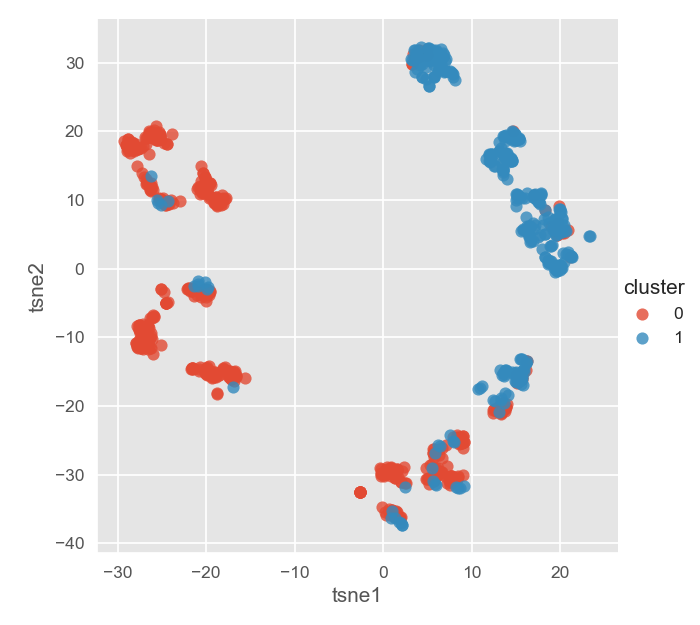

0.9999999999999999


In [6]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = quantitative + qual_encoded
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = df[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=11)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=2)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

In [7]:
len(train)

891

In [8]:
# save PassengerId for final submission
passengerId = test.PassengerId

# merge train and test
titanic = train.append(test, ignore_index=True)

In [9]:
# create indexes to separate data later on
train_idx = len(train)
test_idx = len(titanic) - len(test)

In [10]:
# view head of data
titanic.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [11]:
# get info on features
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [12]:
# PassengerId can be removed from data for now
titanic.drop('PassengerId', axis=1, inplace=True)

In [13]:
# create a new feature to extract title names from the Name column
titanic['Title'] = titanic.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

# view the newly created feature
titanic.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,Mr


In [14]:
# create a new feature to extract title names from the Name column
titanic['Title'] = titanic.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

# view the newly created feature
titanic.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,Mr


In [15]:
# show count of titles
print("There are {} unique titles.".format(titanic.Title.nunique()))

# show unique titles
print("\n", titanic.Title.unique())

There are 18 unique titles.

 ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer' 'Dona']


In [16]:
#As we can see now, we have successfully extracted the title's from the name column. But if we inspect the titles a 
#little more, we see some that can be normalized like "Capt" and "Col" for example are a type of "Officer" 
#and "Mlle" is essentially the French version of "Miss". So now we will normalize these titles so we can 
#cut down the number of titles even more.

In [17]:
# normalize the titles
normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}

In [18]:
# map the normalized titles to the current titles
titanic.Title = titanic.Title.map(normalized_titles)

# view value counts for the normalized titles
print(titanic.Title.value_counts())

Mr         757
Miss       262
Mrs        200
Master      61
Officer     23
Royalty      6
Name: Title, dtype: int64


In [19]:
#For our next step, we are going to assume that their is a relationship between a person's 
#age and their title since it makes sense that someone that is younger is more likely to be a titled a "Miss" vs a "Mrs".

#With this in mind, we will group the data by Sex, Pclass, and Title and then view the median age for the grouped classes.

In [20]:
# group by Sex, Pclass, and Title
grouped = titanic.groupby(['Sex','Pclass', 'Title'])

# view the median Age by the grouped features
grouped.Age.median()

Sex     Pclass  Title  
female  1       Miss       30.0
                Mrs        45.0
                Officer    49.0
                Royalty    39.0
        2       Miss       20.0
                Mrs        30.0
        3       Miss       18.0
                Mrs        31.0
male    1       Master      6.0
                Mr         41.5
                Officer    52.0
                Royalty    40.0
        2       Master      2.0
                Mr         30.0
                Officer    41.5
        3       Master      6.0
                Mr         26.0
Name: Age, dtype: float64

In [21]:
# apply the grouped median value on the Age NaN
titanic.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))

# view changes
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age         1309 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
Fare        1308 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    891 non-null float64
Ticket      1309 non-null object
Title       1309 non-null object
dtypes: float64(3), int64(3), object(6)
memory usage: 122.8+ KB


In [22]:
# fill Cabin NaN with U for unknown
titanic.Cabin = titanic.Cabin.fillna('U')

In [23]:
# find most frequent Embarked value and store in variable
most_embarked = titanic.Embarked.value_counts().index[0]

# fill NaN with most_embarked value
titanic.Embarked = titanic.Embarked.fillna(most_embarked)

In [24]:
# fill NaN with median fare
titanic.Fare = titanic.Fare.fillna(titanic.Fare.median())

# view changes
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age         1309 non-null float64
Cabin       1309 non-null object
Embarked    1309 non-null object
Fare        1309 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    891 non-null float64
Ticket      1309 non-null object
Title       1309 non-null object
dtypes: float64(3), int64(3), object(6)
memory usage: 122.8+ KB


# Exploratory Data Analysis

In [25]:
# view the percentage of those that survived vs. those that died in the Titanic
titanic.Survived.value_counts(normalize=True)

0.0    0.616162
1.0    0.383838
Name: Survived, dtype: float64

In [26]:
#Looks like only 38% of people onboard the Titanic managed to survive its fateful voyage

In [27]:
# group by sex
group_by_sex = titanic.groupby('Sex')

# survival rate by sex
group_by_sex.Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [28]:
#For those of use who are familiar with the fateful story of the Titanic or who have seen the movie, 
#we know that women and children had priority for life boats so these numbers aren't all that surprising. 
#Even knowing that, it is still quite astounding to see that almost 75% of women survived the sinking of 
#the Titanic while only 19% of men did.

In [29]:
# group by passenger class and sex
group_class_sex = titanic.groupby(['Pclass', 'Sex'])

# survival rates by class and sex
group_class_sex.Survived.mean()

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64

# III. Feature Engineering

In [30]:
# size of families (including the passenger)
titanic['FamilySize'] = titanic.Parch + titanic.SibSp + 1

In [31]:
# map first letter of cabin to itself
titanic.Cabin = titanic.Cabin.map(lambda x: x[0])

# view normalized count
titanic.Cabin.value_counts(normalize=True)

U    0.774637
C    0.071811
B    0.049656
D    0.035141
E    0.031322
A    0.016807
F    0.016043
G    0.003820
T    0.000764
Name: Cabin, dtype: float64

In [32]:
# Convert the male and female groups to integer form
titanic.Sex = titanic.Sex.map({"male": 0, "female":1})

In [33]:
# create dummy variables for categorical features

pclass_dummies = pd.get_dummies(titanic.Pclass, prefix="Pclass")
title_dummies = pd.get_dummies(titanic.Title, prefix="Title")
cabin_dummies = pd.get_dummies(titanic.Cabin, prefix="Cabin")
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix="Embarked")

In [34]:
sex_dummies = pd.get_dummies(titanic.Sex, prefix="Sex", drop_first=True)
sex_dummies

,Sex_1
0,0
1,1
2,1
3,1
4,0
5,0
6,0
7,0
8,1
9,1


In [35]:
# concatenate dummy columns with main dataset
titanic_dummies = pd.concat([titanic, pclass_dummies, title_dummies, cabin_dummies, embarked_dummies], axis=1)

# drop categorical fields
titanic_dummies.drop(['Pclass', 'Title', 'Cabin', 'Embarked', 'Name', 'Ticket'], axis=1, inplace=True)

titanic_dummies.head()

,Age,Fare,Parch,Sex,SibSp,Survived,FamilySize,Pclass_1,Pclass_2,Pclass_3,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S
0,22.0,7.2500,0,0,1,0.0,2,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,38.0,71.2833,0,1,1,1.0,2,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,26.0,7.9250,0,1,0,1.0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,35.0,53.1000,0,1,1,1.0,2,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,35.0,8.0500,0,0,0,0.0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1


In [36]:
# create train and test data
titanic_train = titanic_dummies[ :train_idx]
titanic_test = titanic_dummies[test_idx: ]

# convert Survived back to int
titanic_train.Survived = titanic_train.Survived.astype(int)

# Modeling

In [37]:
# create X and y for data and target values
X_train = titanic_train.drop('Survived', axis=1).values
y_train = titanic_train.Survived.values

In [38]:
# create array for test set
X_test = test.values

In [39]:
print(X_train.shape,y_train.shape,X_test.shape)

(891, 27) (891,) (418, 11)


## Rescaling

In [40]:
X_train =X_train.astype('float32')
#X_test =X_test.astype('float32')

In [41]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
#X_test = min_max_scaler.fit_transform(X_test)

In [42]:
X_train

array([[0.2711737 , 0.01415106, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.4722292 , 0.13913573, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.32143757, 0.01546857, 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.22090977, 0.04577135, 0.33333334, ..., 0.        , 0.        ,
        1.        ],
       [0.32143757, 0.0585561 , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.3968334 , 0.01512699, 0.        , ..., 0.        , 1.        ,
        0.        ]], dtype=float32)

### Categorical encoding y

In [43]:
y_train_encoding= tensorflow.keras.utils.to_categorical(y_train,num_classes=2,dtype='float32')


##  train_test_split

In [44]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, y_train_encoding, test_size=0.25,random_state =1 )

## Building and Training Our Neural Network

In [45]:
model = Sequential()

In [46]:
#get number of columns in training data
n_cols = X_train.shape[1]
model = Sequential([
    Dense(4, activation='sigmoid', input_shape=(n_cols,)), #input shape +first hiddden layer
    Dense(2, activation='sigmoid')   
    
])

In [47]:
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [48]:
model.fit(x_train,y_train,epochs = 40)

Epoch 1/40
668/668 [==============================] - 0s 237us/sample - loss: 0.6941 - accuracy: 0.4192
Epoch 2/40
668/668 [==============================] - 0s 37us/sample - loss: 0.6818 - accuracy: 0.6781
Epoch 3/40
668/668 [==============================] - 0s 41us/sample - loss: 0.6715 - accuracy: 0.7275
Epoch 4/40
668/668 [==============================] - 0s 34us/sample - loss: 0.6638 - accuracy: 0.6362
Epoch 5/40
668/668 [==============================] - 0s 35us/sample - loss: 0.6564 - accuracy: 0.6302
Epoch 6/40
668/668 [==============================] - 0s 44us/sample - loss: 0.6502 - accuracy: 0.6302
Epoch 7/40
668/668 [==============================] - 0s 58us/sample - loss: 0.6447 - accuracy: 0.6302
Epoch 8/40
668/668 [==============================] - 0s 44us/sample - loss: 0.6396 - accuracy: 0.6302
Epoch 9/40
668/668 [==============================] - 0s 54us/sample - loss: 0.6350 - accuracy: 0.6302
Epoch 10/40
668/668 [==============================] - 0s 57us/sample - 

## Evaluating the model

In [49]:
from sklearn.metrics import accuracy_score, confusion_matrix
predictions = model.predict(x_test)
print("x_test",type(x_test))
print("x_test",x_test.shape)
print(type(predictions))
print(predictions.shape)
print("Accuracy: %", accuracy_score(y_test.argmax(axis=1), predictions.argmax(axis=1)) * 100)

correct_preds = (y_test.argmax(axis=1) == predictions.argmax(axis=1))
print("That means that out of", y_test.shape[0] ,"test samples, this model got", 
      np.where(correct_preds)[0].size, "correct and",
      np.where(~correct_preds)[0].size, "incorrect")


x_test <class 'numpy.ndarray'>
x_test (223, 27)
<class 'numpy.ndarray'>
(223, 2)
Accuracy: % 79.82062780269058
That means that out of 223 test samples, this model got 178 correct and 45 incorrect


<IPython.core.display.Javascript object>


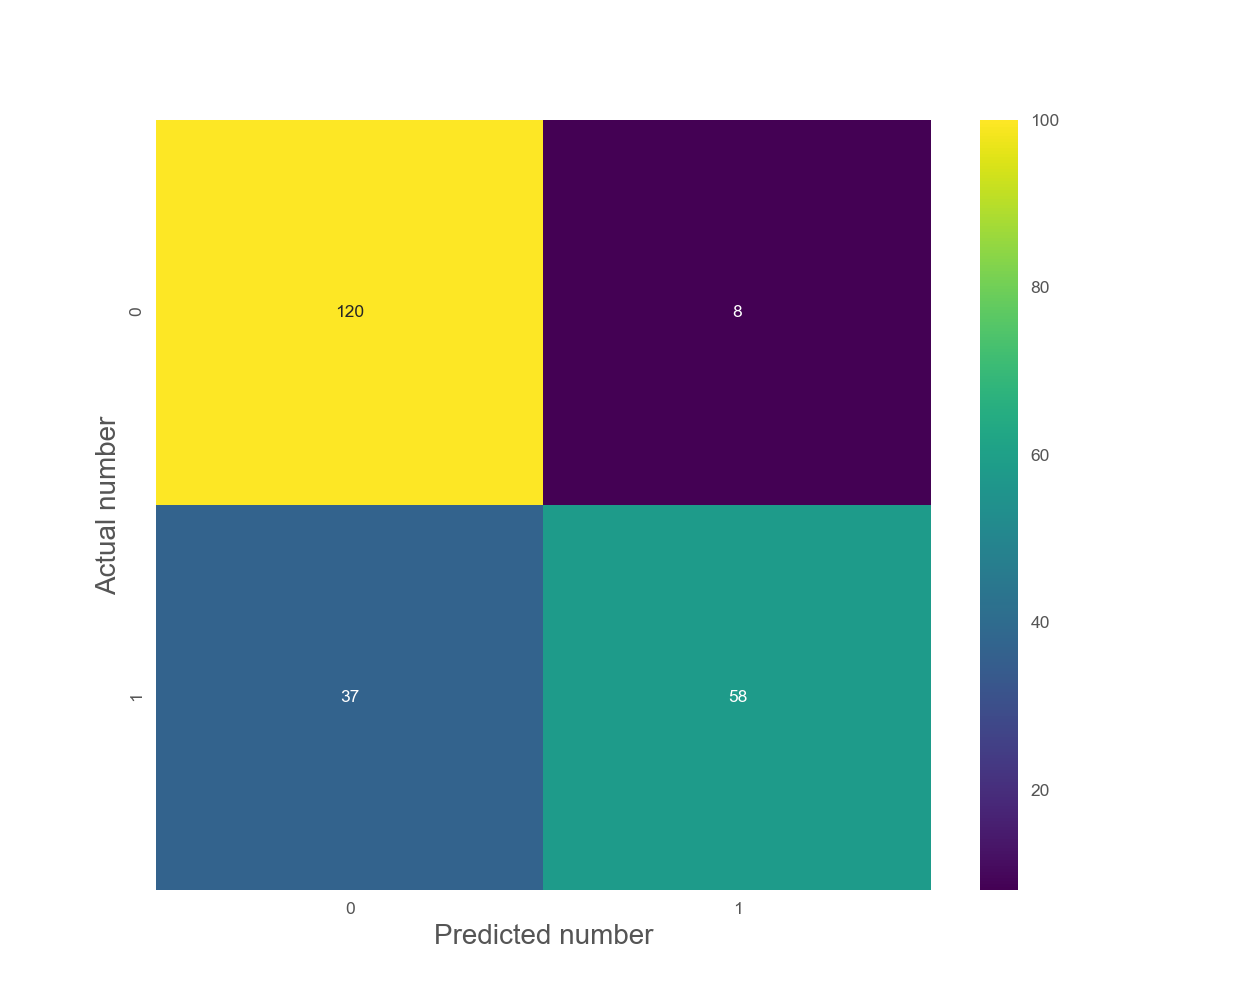

In [51]:
import seaborn as sns
# Import matplotlib
import matplotlib.pyplot as plt 
cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="viridis", vmax=100, annot=True, fmt='g')
plt.gca().set_xlabel("Predicted number", fontsize=16)
plt.gca().set_ylabel("Actual number", fontsize = 16)
plt.show()